# import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split
import numpy as np

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import time
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #this is for pretend kernel die

C:\Users\ayxan\AppData\Local\Temp\ipykernel_25796\2349090238.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# data import, normaliztion, and train/dev/test loader create

In [2]:
data=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')

labels=data[:,0]
data=data[:,1:]

dataNorm=data/np.max(data) #Normaliztion
dataNorm=dataNorm.reshape(dataNorm.shape[0],1,28,28) #change shape

#convert to tensor
dataTen=torch.tensor(dataNorm).float() 
labelTen=torch.tensor(labels).long() #long is integer data type in pytotch

trainData,devtest_data,trainLabel,devtest_label=train_test_split(
                        dataTen,labelTen,train_size=.9)

dev_data,test_data,dev_label,test_label=train_test_split(
                        devtest_data,devtest_label,test_size=.5)

#create datasets
train_dataset=TensorDataset(trainData,trainLabel)
dev_dataset=TensorDataset(dev_data,dev_label)
test_dataset=TensorDataset(test_data,test_label)

#create data loaders
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
dev_loader=DataLoader(dev_dataset,batch_size=dev_dataset.tensors[0].shape[0])
test_loader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

print(f'train_loader shape: {train_loader.dataset.tensors[0].shape}')
print(f'dev_loader shape: {dev_loader.dataset.tensors[0].shape}')
print(f'test_loader shape: {test_loader.dataset.tensors[0].shape}')

train_loader shape: torch.Size([18000, 1, 28, 28])
dev_loader shape: torch.Size([1000, 1, 28, 28])
test_loader shape: torch.Size([1000, 1, 28, 28])


# create CNN model

In [5]:
def createModel(printLayerSize=False):
    
    class cnnModel(nn.Module):
        def __init__(self,printLayerSize):
            super().__init__()
            
            # Convolution layers
            self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=5,
                                stride=1,padding=1)
            
            self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=5,
                                stride=1,padding=1)
            
            #this is size that after from pooling
            expected_size=np.floor((11+2*0-2)/2)+1
            expected_size=20*int(expected_size**2)
            
            # fully connected layer
            self.fc1=nn.Linear(expected_size,50)
            
            self.out=nn.Linear(50,10)
            
            #print toggle
            self.print=printLayerSize
            
        def forward(self,x):
            
            print(f'input shape:{x.shape}') if self.print else None
            
            # CONVOLUTION LAYERS:
            
            # first convolution layer
            x=self.conv1(x)
            x=F.max_pool2d(x,kernel_size=2,stride=2)
            x=F.relu(x)
            print(f'layer conv1/pool1 shape:{x.shape}') if self.print else None
            
            # second convolution layer
            x=self.conv2(x)
            x=F.max_pool2d(x,kernel_size=2,stride=2)
            x=F.relu(x)
            print(f'layer conv2/pool2 shape:{x.shape}') if self.print else None
            
            
            # FEED FORWARD LAYERS:
            
            # reshape output of last pooling for linear layer
            Num_units=x.shape.numel()/x.shape[0]
            x=x.view(-1,int(Num_units))
            print(f'Vectorize shape:{x.shape}') if self.print else None
            
            # input layer
            x=self.fc1(x)
            x=F.relu(x)
            print(f'layer fc1 shape:{x.shape}') if self.print else None
            
            # output layer
            x=self.out(x)
            print(f'output layer shape:{x.shape}') if self.print else None
            
            return x
            
    CNN=cnnModel(printLayerSize)   
    
    loss_fun=nn.CrossEntropyLoss()
    
    optimizer=torch.optim.Adam(CNN.parameters(),lr=.001)
    
    return CNN,loss_fun,optimizer

# model testing

In [7]:
CNN,loss_fun,optimizer=createModel(True)
dat,lab=iter(train_loader).next()
yHat=CNN(dat)

print(' ')
print(yHat.shape)
print(lab.shape)

loss=loss_fun(yHat,lab)
print(' ')
print(f'Loss: {loss}')

input shape:torch.Size([32, 1, 28, 28])
layer conv1/pool1 shape:torch.Size([32, 10, 13, 13])
layer conv2/pool2 shape:torch.Size([32, 20, 5, 5])
Vectorize shape:torch.Size([32, 500])
layer fc1 shape:torch.Size([32, 50])
output layer shape:torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss: 2.322028160095215


# model illustration

In [8]:
summary(CNN,(1,28,28))

input shape:torch.Size([2, 1, 28, 28])
layer conv1/pool1 shape:torch.Size([2, 10, 13, 13])
layer conv2/pool2 shape:torch.Size([2, 20, 5, 5])
Vectorize shape:torch.Size([2, 500])
layer fc1 shape:torch.Size([2, 50])
output layer shape:torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19

# model training

In [9]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
def trainModel(Numepoch=10):
    CNN,loss_fun,optimizer=createModel(False)
    
    losses=torch.zeros(Numepoch)
    trainAcc=[]
    devAcc=[]
    
    theAllTrainTime=time.process_time()
    
    CNN.to(device) # model pass to over gpu
    
    for epoch in range(Numepoch):       
        batchLoss=[]
        batchAcc=[]
        
        startTime=time.process_time()
        
        CNN.train()
        for dat,lab in train_loader:
            dat=dat.to(device) # pass to gpu
            lab=lab.to(device)
            
            yHat=CNN(dat)
            loss=loss_fun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match=(torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*(torch.mean(match)).item())
            
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)
        
        CNN.eval()
        dat,lab=next(iter(dev_loader))
        dat=dat.to(device)
        
        if torch.no_grad():
            yHat=CNN(dat)
        
        yHat=yHat.cpu()
        match=(torch.argmax(yHat,axis=1)==lab).float()
        devAcc.append(100*torch.mean(match))
        
        compleTime=time.process_time()-startTime
        
        msg=f'{epoch+1}th completed:{compleTime:.2f},Train Acc:{trainAcc[-1]}, devolep Acc:{devAcc[-1]}'        
        sys.stdout.write('\r'+msg)
        
    theAllTrainTime=time.process_time()-theAllTrainTime
    
    return CNN,trainAcc,devAcc,losses,theAllTrainTime

7th completed:0.30,Train Acc:98.8489768683274, devolep Acc:98.5training completed at 2.44


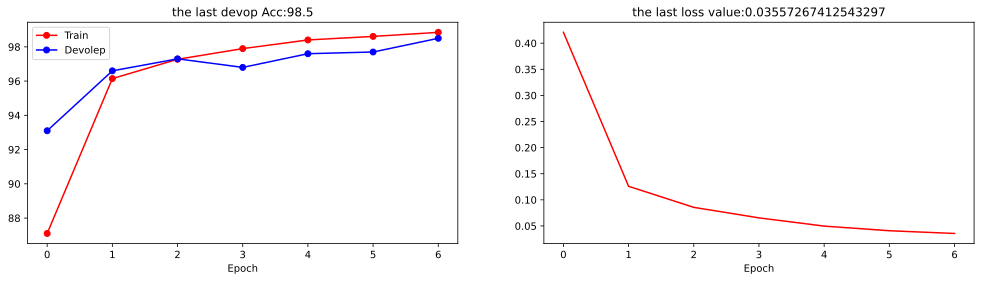

In [11]:
CNN,trainAcc,devAcc,losses,theAllTrainTime=trainModel(7)

fig,ax=plt.subplots(1,2,figsize=(17,4))
print(f'training completed at {theAllTrainTime:.2f}')
ax[0].plot(trainAcc,'ro-',label='Train')
ax[0].plot(devAcc,'bo-',label='Devolep')
ax[0].set_xlabel('Epoch')
ax[0].set_title(f"the last devop Acc:{devAcc[-1]}")
ax[0].legend()

ax[1].plot(losses,'r')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'the last loss value:{losses[-1]}')

plt.show()

# model testing with test dataset

In [12]:
dat,lab=next(iter(test_loader))
dat=dat.to(device)
CNN=CNN.to(device)

prediction=CNN(dat)
prediction=prediction.cpu()
dat=dat.cpu()

preLabel=torch.argmax(prediction,axis=1)
match=(preLabel==lab).float()
accuracy=100*torch.mean(match)

tensor(98.3000)


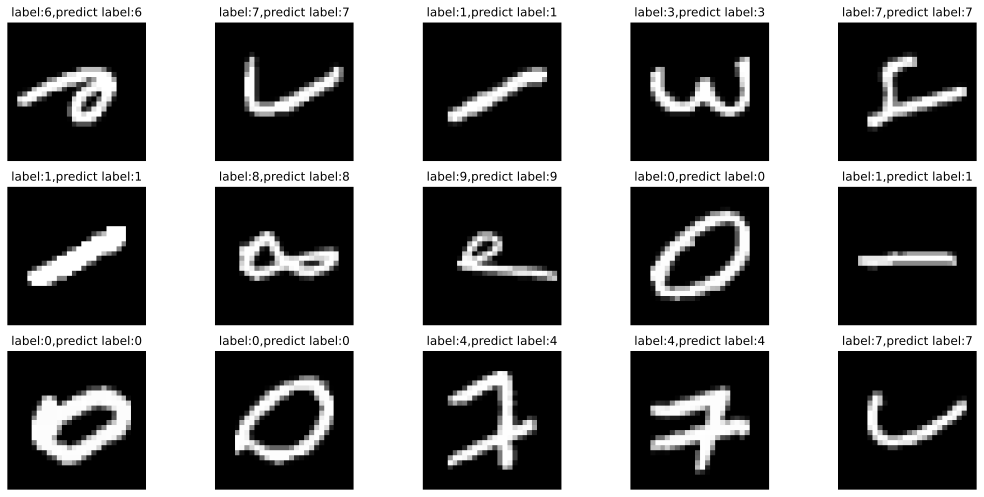

In [13]:
fig,axs=plt.subplots(3,5,figsize=(15,7))
print(accuracy)
for ax in axs.flatten():
    index=np.random.randint(dat.shape[0])
    image=dat[index]
    image=image.permute(2,1,0)
    ax.imshow(image,cmap='gray')
    ax.axis('off')
    ax.set_title(f'label:{lab[index]},predict label:{preLabel[index]}')
    
plt.tight_layout()
plt.show()